[![build status](https://github.com/computorg/{{< meta repo >}}/workflows/build/badge.svg)](https://github.com/computorg/{{< meta repo >}})
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/computorg/{{< meta repo >}}/gh-pages?filepath=content.ipynb)
<!-- [![Creative Commons License](https://i.creativecommons.org/l/by/4.0/80x15.png)](http://creativecommons.org/licenses/by/4.0/) -->

::: {.callout-note icon=false}

## Note

This page is a reworking of the original t-SNE article using the
Computo template. It aims to help authors submitting to the journal by
using some advanced formatting features. We warmly thank the authors
of t-SNE and the editor of JMLR for allowing us to use their work to
illustrate the Computo spirit.

:::

#### Abstract {.unnumbered}

We present a new technique called "t-SNE" that visualizes high-dimensional
data by giving each datapoint a location in a two or three-dimensional map.
The technique is a variation of Stochastic Neighbor Embedding
hinton:stochastic that is much easier to optimize, and produces
significantly better visualizations by reducing the tendency to crowd points
together in the center of the map. t-SNE is better than existing techniques at
creating a single map that reveals structure at many different scales. This is
particularly important for high-dimensional data that lie on several
different, but related, low-dimensional manifolds, such as images of objects
from multiple classes seen from multiple viewpoints. For visualizing the
structure of very large data sets, we show how t-SNE can use random walks on
neighborhood graphs to allow the implicit structure of all the data to
influence the way in which a subset of the data is displayed. We illustrate
the performance of t-SNE on a wide variety of data sets and compare it with
many other non-parametric visualization techniques, including Sammon mapping,
Isomap, and Locally Linear Embedding. The visualization produced by t-SNE are
significantly better than those produced by other techniques on almost all of
the data sets.

#### Keywords {.unnumbered}

visualization, dimensionality reduction, manifold learning, embedding algorithms, multidimensional scaling

# Introduction

Visualization of high-dimensional data is an important problem in many
different domains, and deals with data of widely varying dimensionality. Cell
nuclei that are relevant to breast cancer, for example, are described by
approximately 30 variables @street:nuclear, whereas the pixel
intensity vectors used to represent images or the word-count vectors used to
represent documents typically have thousands of dimensions. Over the last few
decades, a variety of techniques for the visualization of such high-dimensional
data have been proposed, many of which are reviewed by @ferreira:visual.
Important techniques include iconographic displays such as Chernoff faces @chernoff:use, 
pixel-based techniques @keim:designing, and techniques that represent the dimensions in the 
data as vertices in a graph @battista:algorithms. Most of these techniques simply
provide tools to display more than two data dimensions, and leave the
interpretation of the data to the human observer. This severely limits the
applicability of these techniques to real-world data sets that contain
thousands of high-dimensional datapoints.

In contrast to the visualization techniques discussed above, dimensionality
reduction methods convert the high-dimensional data set $\mathcal{X} = {x_1,
x_2, \dots, x_n}$ into two or three-dimensional data $\mathcal{Y} = {y_1, y_2,
\dots, y_n}$ that can be displayed in a scatterplot. In the paper, we refer to
the low-dimensional data representation $\mathcal{Y}$ as a map, and to the
low-dimensional representations $y_i$ of individual datapoints as map
points. The aim of dimensionality reduction is to preserve as much of the
significant structure of the high-dimensional data as possible in the
low-dimensional map. Various techniques for this problem have been proposed
that differ in the type of structure they preserve. Traditional dimensionality
reduction techniques such as Principal Components Analysis
@hotelling:analysis  and classical multidimensional scaling
@torgerson:multidimensional are linear techniques that focus on keeping
the low-dimensional representations of dissimilar datapoints far apart. For
high-dimensional data that lies on or near a low-dimensional, non-linear
manifold it is usually more important to keep the low-dimensional
representations of very similar datapoints close together, which is typically
not possible with a linear mapping.

A large number of nonlinear dimensionality reduction techniques that aim to
preserve the local structure of data have been proposed, many of which are
reviewed by @lee:nonlinear. In particular, we mention the following
seven techniques: (1) Sammon mapping @sammon:nonlinear, (2) curvilinear
components analysis @demartines:curvilinear, (3) Stochastic Neighbor
Embedding @hinton:stochastic; (4) Isomap @tenenbaum:global, (5)
Maximum Variance Unfolding @weinberger:learning; (6) Locally Linear
Embedding @roweis:nonlinear, and (7) Laplacian Eigenmaps
@belkin:laplacian. Despite the strong performance of these techniques
on artificial data sets, they are often not very successful at visualizing
real, high-dimensional data. In particular, most of the techniques are not
capable of retaining both the local and the global structure of the data in a
single map. For instance, a recent study reveals that even a semi-supervised
variant of MVU is not capable of separating handwritten digits into their
natural clusters @song:colored.

In this paper, we describe a way of converting a high-dimensional data
set into a matrix of pairwise similarities and we introduce a new
technique, called "t-SNE", for visualizing the resulting similarity
data. t-SNE is capable of capturing much of the local structure of the
high-dimensional data very well, while also revealing global structure
such as the presence of clusters at several scales. We illustrate the
performance of t-SNE by comparing it to the seven dimensionality
reduction techniques mentioned above on five data sets from a variety
of domains. Because of space limitations, most of the
$(7+1)\times5=40$ maps are presented in the supplemental material, but
the maps that we present in the paper are sufficient to demonstrate
the superiority of t-SNE.

The outline of the paper is as follows. In  @sec-sne, we
outline SNE as presented by @hinton:stochastic, which forms
the basis for t-SNE. In  @sec-tsne, we present t-SNE, which
has two important differences from SNE. In Section
@sec-experiments, we describe the experimental setup and the
results of our experiments.  Subsequently, @sec-large-data shows how t-SNE can be modified to visualize
real-world data sets that contain many more than 10,000
datapoints. The results of our experiments are discussed in more
detail in  @sec-discussion. Our conclusions and suggestions
for future work are presented in  @sec-conclusion.

# Stochastic Neighbor Embedding {#sec-sne}

Stochastic Neighbor Embedding (SNE) starts by converting the
high-dimensional Euclidean distances between datapoints into
conditional probabilities that represent similarities.[^SNE] The
similarity of datapoint $x_j$ to datapoint $x_i$ is the conditional
probabilities, $p_{j|i}$, that $x_i$ would pick $x_j$ as its neighbor
if neighbors were picked in proportion to their probability density
under a Gaussian centered at $x_i$. For nearby datapoints, $p_{j|i}$
is relatively high, whereas for widely separated datapoints, $p_{j|i}$
will be almost infinitesimal (for reasonable values of the variance of
the Gaussian, $\sigma_i$). Mathematically, the conditional probability
$p_{j|i}$ is given by

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2/(2\sigma_i^2))}{\sum_{k\neq i} \exp(-\|x_i
- x_k\|^2 / 2 \sigma_i^2)}\,.
$$ {#eq-sne_large_space}

where $\sigma_i$ is the variance of the Gaussian that is centered on datapoint
$x_i$. The method for determining the value of $\sigma_i$ is presented later
in this section. Because we are only interested in modeling pairwise
similarities, we set the value of $p_{i|i}$ to zero. For the low-dimensional
counterparts $y_i$ and $y_j$ of the high-dimensional datapoints $x_i$ and $x_j$,
it is possible to compute a similar conditional probability, which we denote
by $q_{j|i}$. We set [^variance] the variance of the Gaussian that is employed
in the computation of the conditional probabilities $q_{j|i}$ to
$\frac{1}{\sqrt{2}}$. Hence, we model the similarity of a map point $y_j$ to
map point $y_i$ by

$$
q_{j|i} = \frac{\exp(-\|y_i - y_j\|^2)}{\sum_{k \neq i} \exp(-\|y_i
-y_k\|^2)}\,.
$$

[^SNE]: SNE can also be applied to data sets that consist of pairwise
  similarities between objects rather than high-dimensional vector
  representations of each object, provided these similarities can be
  interpreted as conditional probabilities. For example, human word
  associations data consists of the probability of producing each possible
  word in response to a given word, as a result of which it is already in the
  form required by SNE.

[^variance]: Setting the variance in the low-dimensional Gaussians to another
  value only results in a rescaled version of the final map. Note that by
  using the same variance for every datapoint in the low-dimensional map, we
  lose the property that the data is a perfect model of itself if we embed it
  in a space of the same dimensionality, because in the high-dimensional
  space, we used a different variance $\sigma_i$ in each Gaussian.

Again, since we are only interested in modeling pairwise similarities, we set
$q_{i|i}=0$.

If the map points $y_i$ and $y_j$ correctly model the similarity between the
high-dimensional data-points $x_i$ and $x_j$, the conditional probabilities
$p_{j|i}$ and $q_{j|i}$ will be equal. Motivated by this observation, SNE aims
to find a low-dimensional data representation that minimizes the mismatch
between $p_{j|i}$ and $q_{j|i}$. A natural measure of the faithfulness with
which $q_{j|i}$ models $p_{j|i}$ is the Kullback-Leibler divergence (which is
in the case equal to the cross-entropy up to an additive constant). SNE
minimizes the sum of Kullback-Leibler divergences over all datapoints using a
gradient descent method. The cost function $C$ is given by

$$
C = \sum_i KL(P_i\|Q_i) = \sum_i \sum_j p_{j|i} \log
\frac{p_{j|i}}{q_{j|i}}\,,
$$ {#eq-sne_cost_function}

in which $P_i$ represents the conditional probability distribution
over all other datapoints given datapoint $x_i$, and $Q_i$ represents
the conditional probability distribution over all other map points
given map point $y_i$.  Because the Kullback-Liebler divergence is not
symmetric, different types of error in the pairwise distances in the
low-dimensional map are not weighted equally. In particular, there is
a large cost for using widely separated map points to represent nearby
datapoints (i.e, for using a small $q_{j|i}$ to model a large
$p_{j|i}$), but there is only a small cost for using nearby map points
to represent widely separated datapoints. This small cost comes from
wasting some of the probability mass in the relevant $Q$
distributions. In other words, the SNE cost function focuses on
retaining the local structure of the data in the map (for reasonable
values of the variance of the Gaussian in the high-dimensional space,
$\sigma_i$).


The remaining parameter to be selected the variance $\sigma_i$ of the Gaussian
that is centered over each high-dimensional datapoint, $x_i$.
It is not likely that there is a single value of $\sigma_i$ that is optimal
for all datapoints in the data set because the density of the data is likely
to vary. In dense regions, a smaller value of $\sigma_i$ is usually more
appropriate than in sparser regions. Any particular value of $\sigma_i$
induces a probability distribution, $P_i$, over all of the other datapoints.
This distribution has an entropy which increases as $\sigma_i$ increases. SNE
performs a binary search for the value of $\sigma_i$ that produces a $P_i$
with a fixed perplexity that is specified by the user[^perplexity]. The
perplexity is defined as

$$
Perp(P_i) = 2^{H(P_i)}\,,
$$

where $H(P_i)$ is the Shannon entropy of $P_i$ measured in bits

$$
H(P_i) = - \sum_j p_{j|i} \log_2 p_{j|i}\,.
$$


[^perplexity]: Note that the perplexity increases monotonically with the variance
  $\sigma_i$.

The perplexity can be interpreted as a smooth measure of the effective number
of neighbors. The performance of SNE is fairly robust to changes in the
perplexity, and typical values are between 5 and 50.

The minimization of the cost function in @eq-sne_cost_function is
performed using a gradient descent method. The gradient has a surprisingly
simple form

$$
\frac{\partial C}{\partial y_i} = 2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} -
q_{i|j})(y_i - y_j)\,.
$$

Physically, the gradient may be interpreted as the resultant force created by
a set of springs between the map point $y_i$ and all other map points $y_j$.
All springs exert a force along the direction $(y_i - y_j)$. The spring
between $y_i$ and $y_j$ repels or attracts the map points depending on whether
the distance between the two in the map is too small or too large to represent
the similarities between the two high-dimensional datapoints. The force
exerted by the spring between $y_i$ and $y_j$ is proportional to its length,
and also proportional to its stiffness, which is the mismatch $(p_{j|i} -
q_{j|i} + p_{i|j} + q_{i|j})$ between the pairwise similarities of the data
points.

The gradient descent is initialized by sampling map points randomly from an
isotropic Gaussian with small variance that is centered around the origin. In
order to speed up the optimization and to avoid poor local minima, a
relatively large momentum term is added to the gradient. In other words, the
current gradient is added to an exponentially decaying sum of previous
gradients in order to determine the changes in the coordinates of the map
points at each iteration of the gradient search. Mathematically, the gradient
update with a momentum term is given by

$$
\mathcal{Y}^{(t)} = \mathcal{Y}^{(t-1)} + \eta \frac{\partial C}{\partial
\mathcal{Y}} + \alpha(t) \left( \mathcal{Y}^{(t-1)} - \mathcal{Y}^{(t-2)}\right)\,,
$$

where $\mathcal{Y}^{(t)}$ indicates the solution at iteration $t$, $\eta$
indicates the learning rate, and $\alpha(t)$ represents the momentum at
iteration $t$.

In addition, in the early stages of the optimization, Gaussian noise is added
to the map points after each iteration. Gradually reducing the variance of
this noise performs a type of simulated annealing that helps the optimization
to escape from poor local minima in the cost function. If the variance of the
noise changes very slowly at the critical point at which the global structure
of the map starts to form, SNE tends to find maps with a better global
organization. Unfortunately, this requires sensible choices of the initial
amount of Gaussian noise and the rate at which it decays. Moreover, these
choices interact with the amount of momentum and the step size that are
employed in the gradient descent. It is therefore common to run the
optimization several times on a data set to find appropriate values for the
parameters.[^global_optimization] In this respect, SNE is inferior to methods
that allow convex optimization and it would be useful to find an optimization
method that gives good results without requiring the extra computation time
and parameter choices introduced by the simulated annealing.

[^global_optimization]: Picking the best map after several runs as
  visualization of the data is not nearly as problematic as picking the model
  that does best on a test set during supervised learning. In visualization,
  the aim is to see the structure in the training data, not to generalize to
  held out test data.

# t-Distributed Stochastic Neighbor Embedding {#sec-tsne}

@sec-sne discussed SNE as it was presented by
@hinton:stochastic. Although SNE constructs reasonably good
visualizations, it is hampered by a cost function that is difficult to
optimize and by a problem we refer to as the "crowding problem." In this
section, we present a new technique called "t-Distributed Stochastic Neighbor
Embedding" or "t-SNE" that aims to alleviate these problems. The cost
function used by t-SNE differs from the one used by SNE in two ways: (1) it
uses a symmetrized version of the SNE cost function with simpler gradients
that was briefly introduced by @cook:visualizing and (2) it uses a
Student-t distribution rather than a Gaussian to compute the similarity
between two points *in the low dimensional space*. t-SNE employs a
heavy-tailed distribution in the low-dimensional space to alleviate both the
crowding problem and the optimization problems of SNE.

In this section, we first discuss the symmetric version of SNE (@sec-symmetric_sne).
Subsequently, we discuss the crowding problem
(@sec-crowding), and the use of heavy-tailed distributions to
address this problem (@sec-heavy_tail). We conclude the
 by describing our approach to the optimization of the t-SNE cost
function (@sec-optimization_methods_for_tsne).

## Symmetric SNE {#sec-symmetric_sne}

As an alternative to minimizing the sum of the Kullback-Leibler divergences
between the conditional probabilities $p_{j|i}$ and $q_{j|i}$, it is also
possible to minimize a single Kullback-Leibler divergence between a joint
probability distribution, $P$, in the high-dimensional space and a joint
probability distribution, $Q$, in the low-dimensional space:

$$
C = KL(P\|Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}\,,
$$

where again, we set $p_{ij}$ and $q_{ii}$ to zero. We refer to this type of
SNE as symmetric SNE, because it has the property that $p_{ij} = p_{ji}$ and
$q_{ij} = q_{ji}$ for all $i, j$. In symmetric SNE, the pairwise
similarities in the low-dimensional map $q_{ij}$ are given by

$$
q_{ij} = \frac{\exp(-\|x_i - x_j\|^2)}{\sum_{k\neq l} \exp(-\|x_k -
x_l\|^2)}\,.
$$ {#eq-pairwise_similarities}

The obvious way to define the pairwise similarities in the high-dimensional
space $p_{ij}$ is

$$
p_{ij} = \frac{\exp(-\|x_i - x_j\|^2/2\sigma^2)}{\sum_{k\neq l} \exp(-\|x_k -
x_l\|^2/2\sigma^2)}\,
$$

but this causes problems when a high-dimensional datapoint $x_i$ is an outlier
(i.e., all pairwise distances $\|x_i - x_j\|^2$ are large for $x_i$). For such
an outlier, the values of $p_{ij}$ are extremely small for all $j$, so the
location of its low-dimensional map point $y_i$ has very little effect on the
cost function. As a result, the position of the map point is not well
determined by the positions of the other map points. We circumvent this
problem by defining the joint probabilities $p_{ij}$ in the high dimensional
space to be symmetrized conditional probabilities, that is, we set $p_{ij} =
\frac{p_{j|i} + p_{i|j}}{2n}$. This ensures that $\sum_j p_{ij} >
\frac{1}{2n}$ for all datapoints $x_i$, as a result of which each datapoint
$x_i$ makes a significant contribution to the cost function. In the
low-dimensional space, symmetric SNE simply uses @eq-pairwise_similarities. 
The main advantage of the symmetric version of
SNE is the simpler form of its gradient, which is faster to compute. The
gradient of symmetric SNE is fairly similar to that of asymmetric SNE, and is
given by

$$
\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)\,.
$$

In preliminary experiments, we observed that symmetric SNE seems to produce
maps that are just as good as asymmetric SNE, and sometimes even a little
better.

## The Crowding Problem {#sec-crowding}

Consider a set of datapoints that lie on a two-dimensional curved manifold
which is approximately linear on a small scale, and which is embedded within a
higher-dimensional space. It is possible to model the small pairwise distances
between datapoints fairly well in a two-dimensional map, which is often
illustrated on toy examples such as the "Swiss roll" data set. Now suppose that
the manifold has ten intrinsic dimensions[^dataset] and is embedded within a
space of much higher dimensionality. There are several reasons why the
pairwise distances in a two-dimensional map cannot faithfully model distances
between points on the ten-dimensional manifold. For instance, in ten
dimensions, it is possible to have 11 datapoints that are mutually
equidistant and there is no way to model this faithfully in a two-dimensional
map. A related problem is the very different distribution of pairwise
distances in the two spaces. The volume of a sphere centered on datapoint $i$
scales as $r^m$, where $r$ is the radius and $m$ the dimensionality of the
sphere. So if the datapoints are approximately uniformly distributed in the
region around $i$ on the ten-dimensional manifold, we get the following
"crowding problem:" the area of the two-dimensional map that is available to
accommodate moderately distant datapoints will not be nearly large enough
compared with the area available to accommodate nearby datapoints. Hence, if we
want to model the small distances accurately in the map, most of the points
that are at a moderate distance from datapoint $i$ will have to be placed much
too far away in the two-dimensional map. In SNE, the spring connecting
datapoint $i$ to each of these too-distant map points will thus exert a very
small attractive force. Although these attractive forces are very small, the
very large number of such forces crushes together the points in the center of
the map, which prevents gaps from forming between the natural clusters. Note
that the crowding problem is not specific to SNE, but that it occurs in other
local techniques for multidimensional scaling such as Sammon mapping.

An attempt to address the crowding problem by adding a slight repulsion to all
springs was presented by @cook:visualizing. The slight repulsion is
created by introducing a uniform background model with a small mixing
proportion, $\rho$. So however far apart two map points are, $q_{ij}$ can
never fall below $\frac{2\rho}{n(n-1)}$ (because the uniform background
distribution is over $n(n-1)/2$ pairs). As a result, for datapoints that are
far apart in the high-dimensional space, $q_{ij}$ will always be larger than
$p_{ij}$, leading to a slight repulsion. This technique is called UNI-SNE and
although it usually outperforms standard SNE, the optimization of the UNI-SNE
cost function is tedious. The best optimization method known is to start by
setting the background mixing proportion to zero (i.e., by performing standard
SNE). Once the SNE cost function has been optimized using simulated annealing,
the background mixing proportion can be increased to allow some gaps to form
between natural clusters as shown by @cook:visualizing. Optimizing the
UNI-SNE cost function directly does not work because two map points that are
far apart will get almost all of their $q_{i}$ from the uniform background. So
even if their $p_{ij}$ is large, there will be no attractive force between
them, because a small change in their separation will have a vanishingly small
*proportional* effect on $q_{ij}$. This means that if two parts of a cluster
get separated early on in the optimization, there is no force to pull them
back together.

## Mismatched tails can compensate for mismatched dimensionalities {#sec-heavy_tail}

Since symmetric SNE is actually matching the joint probabilities of pairs of
datapoints in the high-dimensional and the low-dimensional spaces rather than
their distances, we have a natural way of alleviating the crowing problem that
works as follows. In the high-dimensional space, we convert distances into
probabilities using a Gaussian distribution. In the low-dimensional map, we
can use a probability distribution that has a much heavier tails than a
Gaussian to convert distances into probabilities. This allows a moderate
distance in the high-dimensional space to be faithfully modeled by a much
larger distance in the map and, as a result, it eliminates the unwanted
attractive forces between map points that represent moderately dissimilar
datapoints.

In t-SNE, we employ a Student $t$-distribution with a single degree of
freedom (which is the same as a Cauchy distribution) as the heavy-tailed
distribution in the low-dimensional map.  Using this distribution, the joint
probabilities $q_{ij}$ are defined as

$$
q_{ij} = \frac{(1+\|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l}(1+\|y_k -
y_t\|^2)^{-1}}
$$ {#eq-joint_probabilities}

We use a Student t-distribution with a single degree of freedom, because it
has the particularly nice property that $\left(1+\|y_i - y_j\|^2\right)^{-1}$
approaches an inverse square law for large pairwise distances $\|y_i - y_j\|$
in the low-dimensional map. This makes the map's representation of joint
probabilities (almost) invariant to changes in the scale of the map for map
points that are far apart. It also means that large clusters of points that
are far apart interact in just the same way as individual points, so the
optimization operates in the same way at all but the finest scales. A
theoretical justification for our selection of the Student $t$-distribution is
that it is closely related to the Gaussian distribution, as the Student
$t$-distribution is an infinite mixture of Gaussians. A computationally
convenient property is that it is much faster to evaluate the density of a
point under a Student $t$-distribution than under a Gaussian because it does
not involve an exponential, even though the Student $t$-distribution is
equivalent to an infinite mixture of Gaussians with different variances.

The gradient of the Kullback-Leibler divergence between $P$ and the Student-$t$
based joint probability distribution $Q$ (computed using @eq-joint_probabilities)
is derived in Appendix A, and is given by

$$
\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i -
y_j)(1+\|y_i - y_j\|^2)^{-1}\,.
$$ {#eq-gradient-tsne}

:::{#fig-gradients} 

![](figures/gradients.png)

Gradients of three types of SNE as a function of the pairwise Euclidean
distance between two points in the high-dimensional and the pairwise distance
between the points in the low-dimensional data representation.
:::

In @fig-gradients, we show the gradients between the
low-dimensional datapoints $y_i$ and $y_j$ as a function of their
pairwise Euclidean distances in the high-dimensional and the
low-dimensional space (i.e., as a function of $\|x_i-x_j\|$ and
$\|y_i-y_j\|$) for the symmetric versions of SNE, UNI-SNE, and
t-SNE. In the figures, positive values of the gradient represent an
attraction between the low-dimensional datapoints $y_i$ and $y_j$,
whereas negative values represent a repulsion between the two
datapoints. From the figures, we observe two main advantages of the
t-SNE gradient over the gradients of SNE and UNI-SNE.

First, the t-SNE gradient strongly repels dissimilar datapoints that are
modeled by a small pairwise distance in the low-dimensional representation.
SNE has such repulsion as well, but its effect is minimal compared to the
strong attractions elsewhere in the gradient (the largest attraction in our
graphical representation of the gradient is approximately 19, whereas the
largest repulsion is approximately 1). In UNI-SNE, the amount of repulsion
between dissimilar datapoints is slightly larger, however, this repulsion is
only strong when the pairwise distance between the points in the
low-dimensional representation is already large (which is often not the case,
since the low-dimensional representation is initialized by sampling from a
Gaussian with a very small variance that is centered around the origin).

Second, although t-SNE introduces strong repulsions between dissimilar
datapoints that are modeled by small pairwise distances, these repulsions do
not go to infinity. In this respect, t-SNE differs from UNI-SNE, in which the
strength of the repulsion between very dissimilar datapoints is proportional
to their pairwise distance in the low-dimensional map, which may cause
dissimilar datapoints to move much too far away from each other.

Taken together, t-SNE puts emphasis on (1) modeling dissimilar
datapoints by means of large pairwise distances, and (2) modeling
similar datapoints by means of small pairwise distances. Moreover, as
a result of these characteristics of the t-SNE cost function (and as a
result of the approximate scale invariance of the Student
t-distribution), the optimization of the t-SNE cost function is much
easier than the optimization of the cost functions of SNE and
UNI-SNE. Specifically, t-SNE introduces long-range forces in the
low-dimensional map that can pull back together two (clusters of)
similar points that get separated early on in the optimization. SNE
and UNI-SNE do not have such long-range forces, as a result of which
SNE and UNI-SNE need to use simulated annealing to obtain reasonable
solutions. Instead, the long-range forces in t-SNE facilitate the
identification of good local optima without resorting to simulated
annealing

::: {#algo-tsne}

<pre id="tsne">

\begin{algorithm}
\caption{Simple version of t-Distributed Stochastic Neighbor Embeding}
\begin{algorithmic}
\STATE \textbf{Data}: high-dimensional representation $\mathcal{X} = \{x_1, \dots, x_n\}$
\STATE cost function parameters: perplexity  $Perp$
\STATE optimization parameters: number of iterations $T$, learning rate $\eta$, momentum $\alpha(t)$
\STATE \textbf{Result}: low-dimensional data representation $\mathcal{Y}^{(T)} = \{y_1, \dots, y_n\}$
\PROCEDURE{t-sne}{$Perp, T, \eta, \alpha(t)$}
    \STATE compute pairwise affinities $p_{j|i}$ with perplexity $Perp$ (using Equation 1)
    \STATE set $p_{ij} = \frac{1}{2n} (p_{j|i} + p_{i|j})$
    \STATE sample initial solution $\mathcal{Y}^{(0)} = \{y_1,\dots,y_n\}$ from $\mathcal{N}(0,1e^{-4} I)$
    \FOR{$t = 0$ \TO $T$}
        \STATE compute low-dimensional affinities $q_{ij}$ (using Equation 4)
        \STATE compute gradient $\frac{\partial C}{\partial \mathcal{Y}}$ (using Equation 5)
        \STATE et $\mathcal{Y}^{t} = \mathcal{Y}^{t-1} + \eta \frac{\partial C}{\partial \mathcal{Y}} + \alpha(t) \left(\mathcal{Y}^{t-1} - \mathcal{Y}^{t-2}\right)$ 
    \ENDFOR
\ENDPROCEDURE
\end{algorithmic}
\end{algorithm}
</pre>

:::

## Optimization methods for t-SNE {#sec-optimization_methods_for_tsne}

We start by presenting a relatively simple, gradient descent procedure for
optimizing the t-SNE cost function. This simple procedure uses a momentum term
to reduce the number of iterations required and it works best if the momentum
term is small until the map points have become moderately well organized.
Pseudocode for this simple algorithm is presented in Algorithm 1 (FIXME: ref not working). The
simple algorithm can be sped up using the adaptive learning rate scheme that
is described by @jacobs:rates, which gradually increases the learning
rate in directions in which the gradient is stable.

Although the simple algorithm produces visualizations that are often much
better than those produced by other non-parametric dimensionality reduction
techniques, the results can be improved further by using either of two tricks.
The first trick, which we call "early compression," is to force the map points
to stay close together at the start of the optimization. When the distances
between map points are small, it is easy for clusters to move through one
another so it is much easier to explore the space of possible global
organizations of the data. Early compression is implemented by adding an
additional L2-penalty to the cost function that is proportional to the sum of
squared distances of the map points from the origin. The magnitude of this
penalty term and the iteration at which it is removed are set by hand, but the
behavior is fairly robust across variations in these two additional
optimization parameters.

A less obvious way to improve the optimization, which we call "early
exaggeration," is to multiply all of the $p_{ij}$'s by, for example, 4, in the
initial stages of the optimization. This means that almost all of the
$q_{ij}$'s, which still add up to 1, are much too small to model their
corresponding $p_{ij}$'s. As a result, the optimization is encouraged to focus
on modeling the large $p_{ij}$'s by fairly large $q {ij}$'s. The effect is
that the natural clusters in the data tend to form tight widely separated
clusters in the map. This creates a lot of relatively empty space in the map,
which makes it much easier for the clusters to move around relative to one
another in order to find a good global organization.

In all the visualizations presented in this paper and in the
supporting material, we used exactly the same optimization
procedure. We used the early exaggeration method with an exaggeration
of 4 for the first 50 iterations (note that early exaggeration is not
included in the pseudocode in Algorithm 1). The number of
gradient descent iterations $T$ was set 1000, and the momentum term
was set to $\alpha^{(t)} = 0.5$ for $t<250$ and $\alpha^{(t)}=0.8$ for
$t \geq 250$. The learning rate $\eta$ is initially set to 100 and it
is updated after every iteration by means of the adaptive learning
rate scheme described by @jacobs:rates. A Matlab implementation of the
resulting algorithm is available at
<https://lvdmaaten.github.io/tsne/>.

# Experiments {#sec-experiments}

To evaluate t-SNE, we present experiments in which t-SNE is compared to seven
other non-parametric techniques for dimensionality reduction. Because of space
limitations, in the paper, we only compare t-SNE with: (1) Sammon mapping, (2)
Isomap, and (3) LLE. In the supporting material, we also compare t-SNE with:
(4) CCA, (5) SNE, (6) MVU, and (7) Laplacian Eigenmaps. We performed
experiments on five data sets that represent a variety of application domains.
Again, because of space limitations, we restrict ourselves to three data sets
in the paper. The results of our experiments on the remaining two data sets
are presented in the supplementary material.

In @sec-datasets, the data sets that we employed in our
experiments are introduced. The setup of the experiments is presented in
@sec-experimental_setup. In @sec-results, we
present the results of our experiments.

## Data Sets {#sec-datasets}

The five data sets we employed in our experiments are: (1) the MNIST data set,
(2) the Olivetti faces data set, (3) the COIL-20 data set, (4) the
word-features data set, and (5) the Netflix data set. We only present results
on the first three data sets in this section. The results on the remaining two
data sets are presented in the supporting material. The first three data sets
are introduced below.

The MNIST data set[^MNIST] contains 60,000 grayscale images of
handwritten digits. For our experiments, we randomly selected 6,000 of
the images for computational reasons. The digit images have $28 \times
28 = 784$ pixels (i.e., dimensions). The Olivetti faces data
set[^Olivetti] consists of images of 40 individuals with small
variations in viewpoint, large variations in expression, and
occasional addition of glasses. The data set consists of 400 images
(10 per individual) of size $92\times 112=10,304$ pixels, and is
labeled according to identity. The COIL-20 data set
@nene:coil20 contains images of 20 different objects viewed
from 72 equally spaced orientations, yielding a total of 1,440
images. The images contain $32 \times 32 = 1,024$ pixels.

[^MNIST]: The MNIST data set is publicly available from <http://yann.lecun.com/exdb/mnist/index.html>.

[^Olivetti]: The Olivetti data set is publicly available from <http://mambo.ucsc.edu/psl/olivetti.html>.

## Experimental Setup {#sec-experimental_setup}

In all of our experiments, we start by using PCA to reduce the dimensionality
of the data to 30. This speeds up the computation of pairwise distances
between the datapoints and suppresses some noise without severely distorting
the interpoint distances. We then use each of the dimensionality reduction
techniques to convert the 30-dimensional representation to a two-dimensional
map and we show the resulting map as a scatterplot. For all of the data sets,
there is information about the class of each datapoint, but the class
information is only used to select a color and/or symbol for the map points.
The class information is not used to determine the spatial coordinates of the
map points. The coloring thus provides a way of evaluating how well the map
preserves the similarities within each class.

The cost function parameter settings we employed in our experiments are listed
in @tbl-cost-function-parameters. In the table, $Perp$ represents the
perplexity of the conditional probability distribution induced by a Gaussian
kernel and $k$ represents the number of nearest neighbors employed in a
neighborhood graph. In the experiments with Isomap and LLE, we only visualize
datapoints that correspond to vertices in the largest connected component of
the neighborhood graph. [^neighborhood_graph] For the Sammon mapping
optimization, we performed Newton's method for 500 iterations.

[^neighborhood_graph]: Isomap and LLE require data that gives rise to a
  neighborhood graph that is connected.

| Technique      | Cost function parameters |
|----------------|-------------------------:|
| t-SNE          | $Perp = 40$              |
| Sammon mapping | none                     |
| Isomap         | $k=12$                   |
| LLE            | $k=12$                   |

: Cost function parameter settings for the experiments {#tbl-cost-function-parameters}

## Results {#sec-results}

________________________________________________________________________________
[Memory] Calling sklearn.manifold._t_sne.fit_transform...
fit_transform(array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]))


/usr/share/miniconda3/envs/computo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/usr/share/miniconda3/envs/computo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


____________________________________________________fit_transform - 8.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.manifold._mds.fit_transform...
fit_transform(array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]))


__________________________________________________fit_transform - 110.4s, 1.8min


Text(0.5, 1.0, 'Visualization by Sammon mapping.')

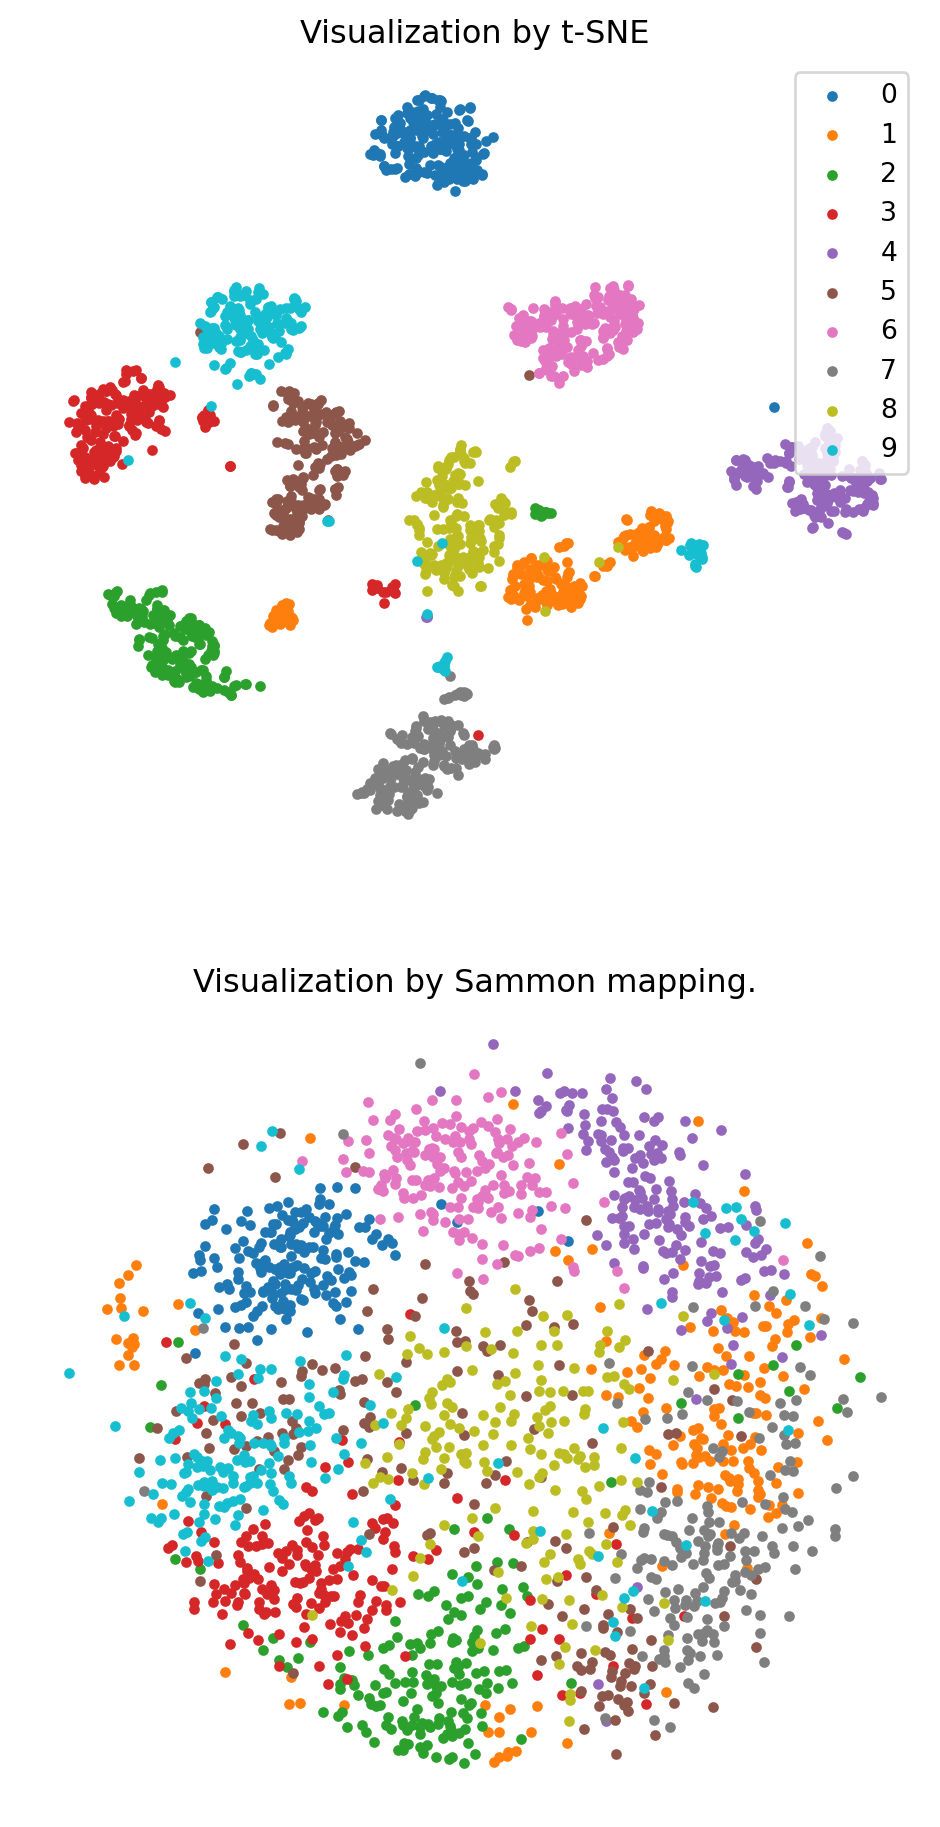

In [1]:
###############################################################################
# Figure 2. Visualization by t-SNE and Sammon mapping
###############################################################################

from sklearn.datasets import load_digits
import numpy as np
from sklearn import manifold
import joblib

import matplotlib.pyplot as plt


mem = joblib.Memory(".joblib")


digits = load_digits()

X = digits["data"]
y = digits["target"]

n_components = 2


colors = {
    0: "C0",
    1: "C1",
    2: "C2",
    3: "C3",
    4: "C4",
    5: "C5",
    6: "C6",
    7: "C7",
    8: "C8",
    9: "C9",
}

fig, axes = plt.subplots(nrows=2, figsize=(6, 12))

###############################################################################
# t-SNE manifold learning
ax = axes[0]

tsne = manifold.TSNE(n_components=n_components, init="pca", random_state=42)
X_transformed = mem.cache(tsne.fit_transform)(X)
for label in np.unique(y):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=colors[label], marker=".",
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by t-SNE")
ax.legend()

###############################################################################
# Sammon mapping

# FIXME I think Sammon mapping has weights?
ax = axes[1]
embedding = manifold.MDS(n_components=n_components)
X_transformed = mem.cache(embedding.fit_transform)(X)
for label in np.unique(y):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=colors[label], marker=".",
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by Sammon mapping.")

________________________________________________________________________________
[Memory] Calling sklearn.manifold._isomap.fit_transform...
fit_transform(array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]))


____________________________________________________fit_transform - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.manifold._locally_linear.fit_transform...
fit_transform(array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]))


____________________________________________________fit_transform - 0.4s, 0.0min


Text(0.5, 1.0, 'Visualization by LLE.')

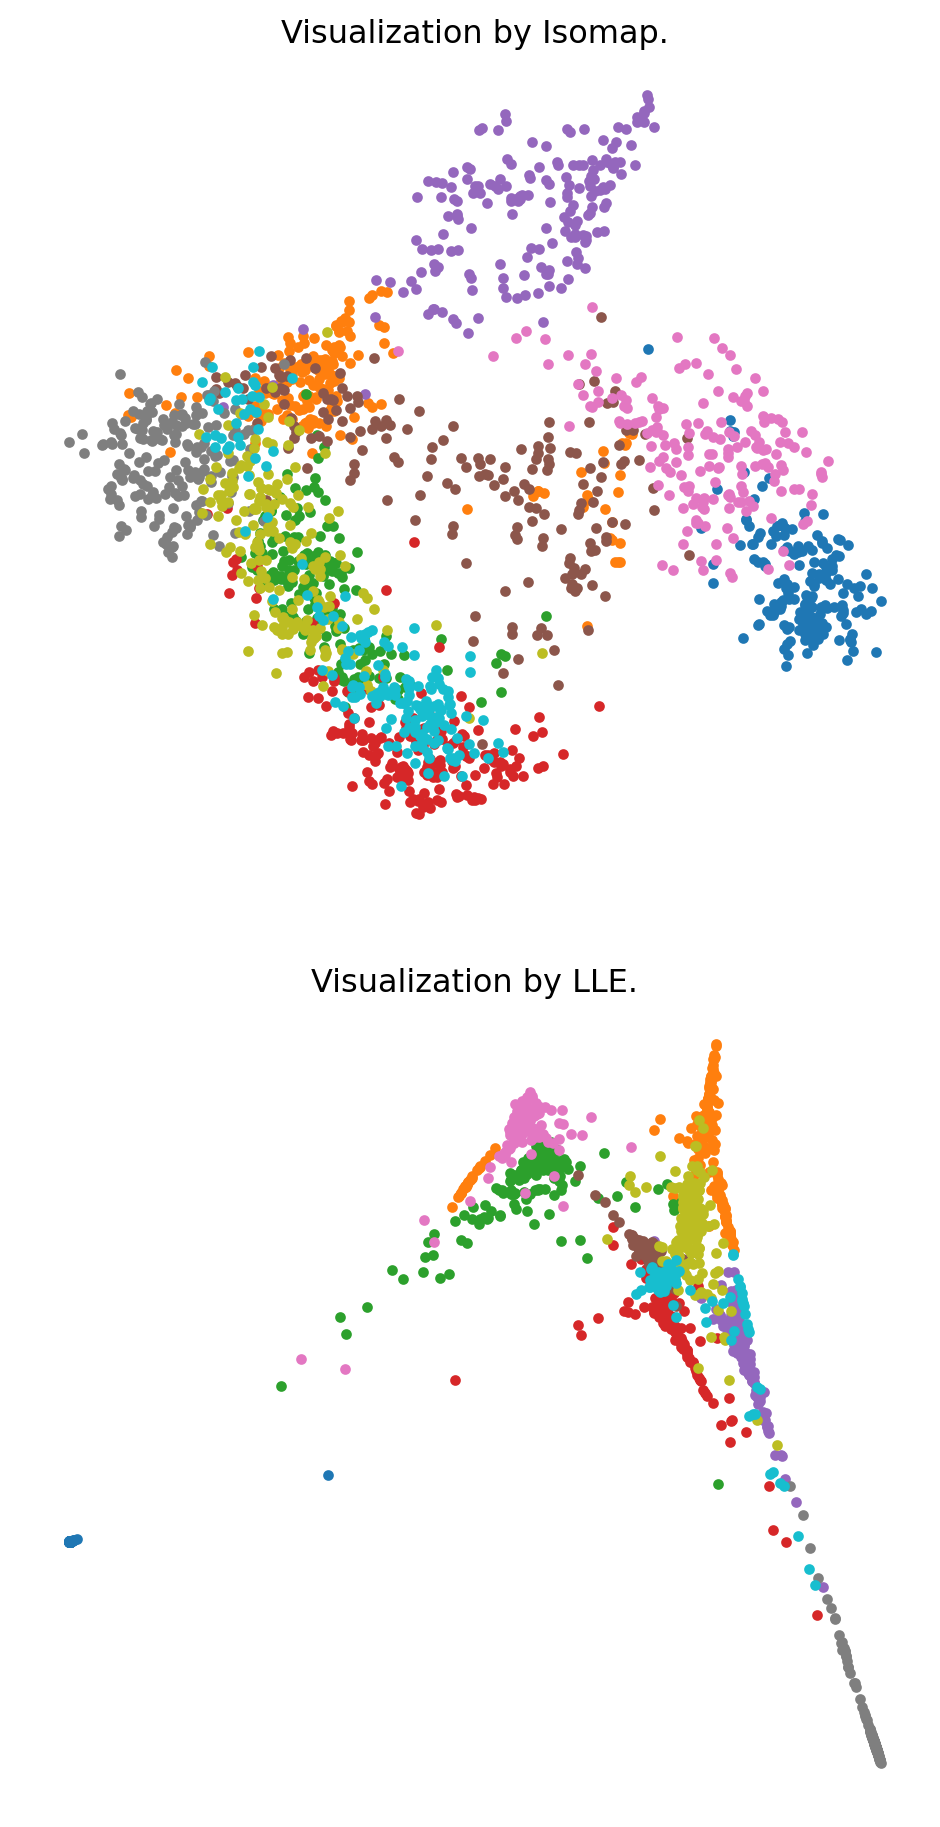

In [2]:
###############################################################################
# Figure 3. Visualization by Isomap and LLE
###############################################################################

fig, axes = plt.subplots(nrows=2, figsize=(6, 12))

###############################################################################
# ISOMAP
ax = axes[0]
isomap = manifold.Isomap(n_components=n_components, n_neighbors=10)
X_transformed = mem.cache(isomap.fit_transform)(X)
for label in np.unique(y):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=colors[label], marker=".",
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by Isomap.")

###############################################################################
# LLE
ax = axes[1]
embedding = manifold.LocallyLinearEmbedding(
    n_components=n_components,
    n_neighbors=10)
X_transformed = mem.cache(embedding.fit_transform)(X)
for label in np.unique(y):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=colors[label], marker=".",
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by LLE.")

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/runner/scikit_learn_data


________________________________________________________________________________
[Memory] Calling sklearn.manifold._t_sne.fit_transform...
fit_transform(array([[0.309917, ..., 0.157025],
       ...,
       [0.516529, ..., 0.384298]], dtype=float32))


/usr/share/miniconda3/envs/computo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/share/miniconda3/envs/computo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


____________________________________________________fit_transform - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.manifold._mds.fit_transform...
fit_transform(array([[0.309917, ..., 0.157025],
       ...,
       [0.516529, ..., 0.384298]], dtype=float32))


____________________________________________________fit_transform - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.manifold._isomap.fit_transform...
fit_transform(array([[0.309917, ..., 0.157025],
       ...,
       [0.516529, ..., 0.384298]], dtype=float32))


____________________________________________________fit_transform - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.manifold._locally_linear.fit_transform...
fit_transform(array([[0.309917, ..., 0.157025],
       ...,
       [0.516529, ..., 0.384298]], dtype=float32))


____________________________________________________fit_transform - 0.2s, 0.0min


Text(0.5, 1.0, 'Visualization by LLE.')

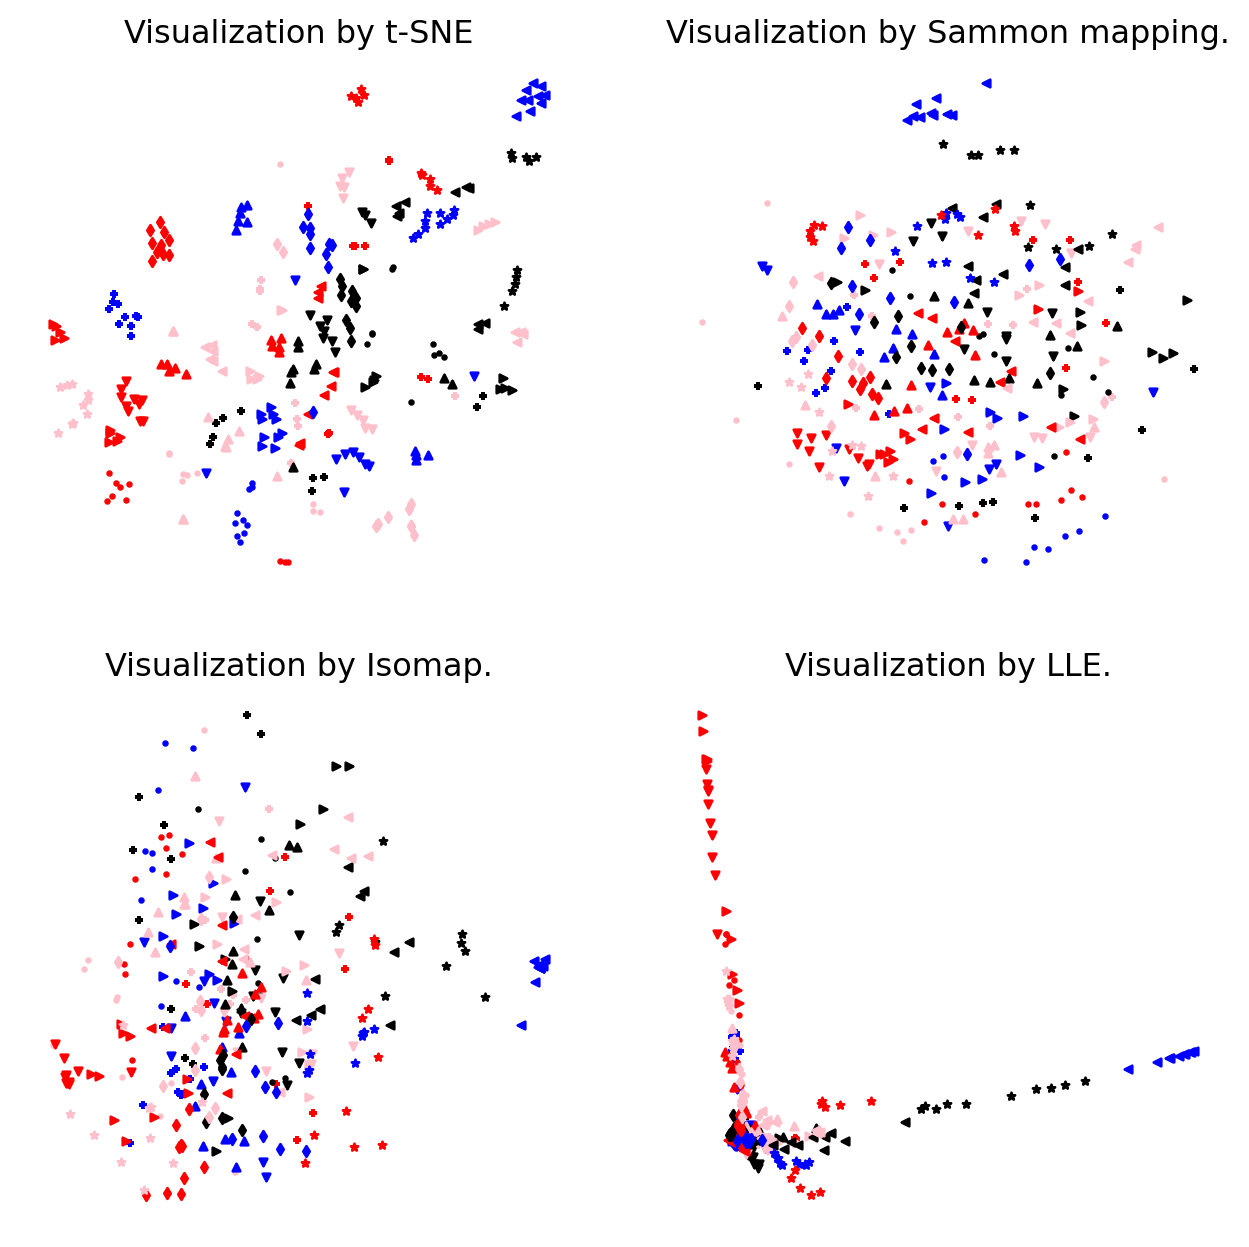

In [3]:
###############################################################################
# Figure 4. Visualization of the Olivetti faces data set
###############################################################################

# First, load the olivetti datasets
from sklearn.datasets import fetch_olivetti_faces
import itertools

data = fetch_olivetti_faces()
X = data["data"]
y = data["target"]

markers = ["+", ".", "v", "^", ">", "<", "d", "*"]
colors = ["black", "blue", "red", "pink"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

###############################################################################
# t-SNE manifold learning
ax = axes[0, 0]

tsne = manifold.TSNE(n_components=n_components, init="pca", random_state=42)
X_transformed = mem.cache(tsne.fit_transform)(X)
for label, (m, c) in zip(np.unique(y), itertools.product(markers, colors)):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
	marker=m, c=c,
	s=8,
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by t-SNE")

###############################################################################
# Sammon mapping

ax = axes[0, 1]
embedding = manifold.MDS(n_components=n_components)
X_transformed = mem.cache(embedding.fit_transform)(X)
for label, (m, c) in zip(np.unique(y), itertools.product(markers, colors)):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
	marker=m, c=c,
	s=8,
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by Sammon mapping.")

###############################################################################
# ISOMAP
ax = axes[1, 0]
isomap = manifold.Isomap(n_components=n_components, n_neighbors=10)
X_transformed = mem.cache(isomap.fit_transform)(X)
for label, (m, c) in zip(np.unique(y), itertools.product(markers, colors)):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
	marker=m, c=c,
	s=8,
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by Isomap.")

###############################################################################
# LLE
ax = axes[1, 1]
embedding = manifold.LocallyLinearEmbedding(
    n_components=n_components,
    n_neighbors=10)
X_transformed = mem.cache(embedding.fit_transform)(X)

for label, (m, c) in zip(np.unique(y), itertools.product(markers, colors)):
    mask = y == label
    ax.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
	marker=m, c=c,
	s=8,
        label=label)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualization by LLE.")

In Figures 2 and 3, we show the results of our experiments with t-SNE,
Sammon mapping, Isomap, and LLE on the MNIST data set. The results
reveal the strong performance of t-SNE compared to the other
techniques. In particular, Sammon mapping constructs a "ball" in which
only three classes (representing the digits 0, 1, and 7) are somewhat
separated from the other classes. Isomap and LLE produce solutions in
which there are large overlaps between the digit classes. In contrast,
tSNE constructs a map in which the separation between the digit
classes is almost perfect. Moreover, detailed inspection of the t-SNE
map reveals that much of the local structure of the data (such as the
orientation of the ones) is captured as well. This is illustrated in
more detail in @sec-large-data (see Figure 7). The map produced by t-SNE
contains some points that are clustered with the wrong class, but most
of these points correspond to distorted digits many of which are
difficult to identify.  Figure 4 shows the results of applying t-SNE,
Sammon mapping, Isomap, and LLE to the Olivetti faces data set. Again,
Isomap and LLE produce solutions that provide little insight into the
class structure of the data. The map constructed by Sammon mapping is
significantly better, since it models many of the members of each
class fairly close together, but none of the classes are clearly
separated in the Sammon map. In contrast, t-SNE does a much better job
of revealing the natural classes in the data. Some individuals have
their ten images split into two clusters, usually because a subset of
the images have the head facing in a significantly different
direction, or because they have a very different expression or
glasses. For these individuals, it is not clear that their ten images
form a natural class when using Euclidean distance in pixel space.

Figure 5 shows the results of applying t-SNE, Sammon mapping, Isomap,
and LLE to the COIL20 data set. For many of the 20 objects, t-SNE
accurately represents the one-dimensional manifold of viewpoints as a
closed loop. For objects which look similar from the front and the
back, t-SNE distorts the loop so that the images of front and back are
mapped to nearby points. For the four types of toy car in the COIL-20
data set (the four aligned "sausages" in the bottom-left of the tSNE
map), the four rotation manifolds are aligned by the orientation of
the cars to capture the high similarity between different cars at the
same orientation. This prevents t-SNE from keeping the four manifolds
clearly separate. Figure 5 also reveals that the other three
techniques are not nearly as good at cleanly separating the manifolds
that correspond to very different objects. In addition, Isomap and LLE
only visualize a small number of classes from the COIL-20 data set,
because the data set comprises a large number of widely separated
submanifolds that give rise to small connected components in the
neighborhood graph.

# Applying t-SNE to Large Data Sets {#sec-large-data}

Like many other visualization techniques, t-SNE has a computational
and memory complexity that is quadratic in the number of
datapoints. This makes it infeasible to apply the standard version of
t-SNE to data sets that contain many more than, say, 10,000
points. Obviously, it is possible to pick a random subset of the
datapoints and display them using t-SNE, but such an approach fails to
make use of the information that the undisplayed datapoints provide
about the underlying manifolds.  Suppose, for example, that A, B, and
C are all equidistant in the high-dimensional space. If there are many
undisplayed datapoints between A and B and none between A and C, it is
much more likely that A and B are part of the same cluster than A and
C. This is illustrated in @fig-random_walk. In this section, we
show how t-SNE can be modified to display a random subset of the
datapoints (so-called landmark points) in a way that uses information
from the entire (possibly very large) data set.

::: {#fig-random_walk} 

![](figures/random_walk.png)

An illustration of the advantage of the random walk version of t-SNE over a standard
landmark approach. The shaded points A, B, and C are three (almost) equidistant landmark points, whereas the non-shaded datapoints are non-landmark points. The arrows represent a directed neighborhood graph where $k = 3$. In a standard landmark approach, the pairwise affinity between A and B is approximately equal to the pairwise affinity between A and C. In the random walk version of t-SNE, the pairwise affinity between A and B is much larger than the pairwise affinity between A and C, and therefore, it reflects the structure of the data much better.
:::

We start by choosing a desired number of neighbors and creating a
neighborhood graph for all of the datapoints. Although this is
computationally intensive, it is only done once. Then, for each of the
landmark points, we define a random walk starting at that landmark
point and terminating as soon as it lands on another landmark
point. During a random walk, the probability of choosing an edge
emanating from node xi to node x j is proportional to $e^{-\|x_i−x_j
\|^2}$ . We define $p_{j|i}$ to be the fraction of random walks
starting at landmark point $x_i$ that terminate at landmark point
$x_j$ . This has some resemblance to the way Isomap measures pairwise
distances between points. However, as in diffusion maps
@lafon:diffusion,@nadler:diffusion, rather than looking
for the shortest path through the neighborhood graph, the random
walk-based affinity measure integrates over all paths through the
neighborhood graph. As a result, the random walk-based affinity
measure is much less sensitive to "short-circuits"
@lee:nonlinear2005, in which a single noisy datapoint provides a
bridge between two regions of dataspace that should be far apart in
the map. Similar approaches using random walks have also been
successfully applied to, for example, semi-supervised learning
@jaakola:partially,@zhu:semi and image segmentation
@grady:random.

The most obvious way to compute the random walk-based similarities
$p_{j|i}$ is to explicitly perform the random walks on the
neighborhood graph, which works very well in practice, given that one
can easily perform one million random walks per second. Alternatively,
@grady:random presents an analytical solution to compute the
pairwise similarities $p_{j|i}$ that involves solving a sparse linear
system. The analytical solution to compute the similarities $p_{j|i}$
is sketched in Appendix B (FIXME). In preliminary experiments, we did not find
significant differences between performing the random walks explicitly
and the analytical solution. In the experiment we present below, we
explicitly performed the random walks because this is computationally
less expensive. However, for very large data sets in which the
landmark points are very sparse, the analytical solution may be more
appropriate.

::: {#fig-random_walk_tsne} 

![](figures/random_walk_tSNE.png)

Visualization of 6,000 digits from the MNIST data set produced by the random walk
version of t-SNE (employing all 60,000 digit images).
:::

@fig-random_walk_tsne shows the results of an experiment, in which we
applied the random walk version of t-SNE to 6,000 randomly selected
digits from the MNIST data set, using all 60,000 digits to compute the
pairwise affinities $p_{j|i}$. In the experiment, we used a
neighborhood graph that was constructed using a value of $k = 20$
nearest neighbors.[^knn] The inset of the figure shows the same
visualization as a scatterplot in which the colors represent the
labels of the digits. In the t-SNE map, all classes are clearly
separated and the "continental" sevens form a small separate cluster.
Moreover, t-SNE reveals the main dimensions of variation within each
class, such as the orientation of the ones, fours, sevens, and nines,
or the "loopiness" of the twos. The strong performance of t-SNE is
also reflected in the generalization error of nearest neighbor
classifiers that are trained on the low-dimensional
representation. Whereas the generalization error (measured using
10-fold cross validation) of a 1-nearest neighbor classifier trained
on the original 784-dimensional datapoints is 5.75%, the
generalization error of a 1-nearest neighbor classifier trained on the
two-dimensional data representation produced by t-SNE is only
5.13%. The computational requirements of random walk t-SNE are
reasonable: it took only one hour of CPU time to construct the map in
@fig-random_walk_tsne.

[^knn]: In preliminary experiments, we found the performance of random
    walk t-SNE to be very robust under changes of $k$.

# Discussion {#sec-discussion}

The results in the previous two sections (and those in the
supplemental material) demonstrate the performance of t-SNE on a wide
variety of data sets. In this section, we discuss the differences
between t-SNE and other non-parametric techniques
([ 6.1](sec-comparison)), and we also discuss a number of
weaknesses and possible improvements of t-SNE
([ 6.2](sec-weakness)).

## Comparison with Related Techniques {#sec-comparison}

Classical scaling @torgerson:multidimensional, which is closely
related to PCA @mardia:multivariate
@williams:connection, finds a linear transformation of the data
that minimizes the sum of the squared errors between high-dimensional
pairwise distances and their low-dimensional representatives. A linear
method such as classical scaling is not good at modeling curved
manifolds and it focuses on preserving the distances between widely
separated datapoints rather than on preserving the distances between
nearby datapoints. An important approach that attempts to address the
problems of classical scaling is the Sammon mapping
@sammon:nonlinear which alters the cost function of classical
scaling by dividing the squared error in the representation of each
pairwise Euclidean distance by the original Euclidean distance in the
high-dimensional space. The resulting cost function is given by

$$
	C = \frac{1}{\sum_{ij} \|x_i - x_j\|} \sum_{i \neq j} \frac{\left(\|x_i - x_j\| - \|x_i - x_j\|\right)^2}{\|x_i - x_j\|}\,
$$

where the constant outside of the sum is added in order to simplify
the derivation of the gradient.  The main weakness of the Sammon cost
function is that the importance of retaining small pairwise distances
in the map is largely dependent on small differences in these pairwise
distances. In particular, a small error in the model of two
high-dimensional points that are extremely close together results in a
large contribution to the cost function. Since all small pairwise
distances constitute the local structure of the data, it seems more
appropriate to aim to assign approximately equal importance to all
small pairwise distances.

In contrast to Sammon mapping, the Gaussian kernel employed in the
high-dimensional space by t-SNE defines a soft border between the
local and global structure of the data and for pairs of datapoints
that are close together relative to the standard deviation of the
Gaussian, the importance of modeling their separations is almost
independent of the magnitudes of those separations. Moreover, t-SNE
determines the local neighborhood size for each datapoint separately
based on the local density of the data (by forcing each conditional
probability distribution $P_i$ to have the same perplexity).

The strong performance of t-SNE compared to Isomap is partly explained
by Isomap’s susceptibility to “short-circuiting”. Also, Isomap mainly
focuses on modeling large geodesic distances rather than small ones.

The strong performance of t-SNE compared to LLE is mainly due to a
basic weakness of LLE: the only thing that prevents all datapoints
from collapsing onto a single point is a constraint on the covariance
of the low-dimensional representation. In practice, this constraint is
often satisfied by placing most of the map points near the center of
the map and using a few widely scattered points to create large
covariance (see Figure FIXME). For neighborhood graphs that are almost
disconnected, the covariance constraint can also be satisfied by a
“curdled” map in which there are a few widely separated, collapsed
subsets corresponding to the almost disconnected components.
Furthermore, neighborhood-graph based techniques (such as Isomap and
LLE) are not capable of visualizing data that consists of two or more
widely separated submanifolds, because such data does not give rise to
a connected neighborhood graph. It is possible to produce a separate
map for each connected component, but this loses information about the
relative similarities of the separate components.

Like Isomap and LLE, the random walk version of t-SNE employs
neighborhood graphs, but it does not suffer from short-circuiting
problems because the pairwise similarities between the highdimensional
datapoints are computed by integrating over all paths through the
neighborhood graph.  Because of the diffusion-based interpretation of
the conditional probabilities underlying the random walk version of
t-SNE, it is useful to compare t-SNE to diffusion maps. Diffusion maps
define a "diffusion distance" on the high-dimensional datapoints that
is given by

$$ 
D^{(t)}(x_i,x_j) = \sqrt{ \sum_{k} \frac{\left(p^{(t)}_{ik} -
p^{(t)}_{jk}\right)^2)}{\psi(x_k)^{(0)}} }\,
$$

where $p^{(t)}_{ij}$ represents the probability of a particle
traveling from $x_i$ to $x_j$ in $t$ timesteps through a graph on the
data with Gaussian emission probabilities. The term $\psi(x_k)^{(0)}$
is a measure for the local density of the points, and serves a similar
purpose to the fixed perplexity Gaussian kernel that is employed in
SNE. The diffusion map is formed by the principal non-trivial
eigenvectors of the Markov matrix of the random walks of length
$t$. It can be shown that when all $(n−1)$ non-trivial eigenvectors
are employed, the Euclidean distances in the diffusion map are equal
to the diffusion distances in the high-dimensional data representation
@lafon:diffusion. Mathematically, diffusion maps minimize

$$
C = \sum_i \sum_j \left(D^{(t)}(x_i,x_j) - \|y_i-y_j\|\right)^2
$$

As a result, diffusion maps are susceptible to the same problems as
classical scaling: they assign much higher importance to modeling the
large pairwise diffusion distances than the small ones and as a
result, they are not good at retaining the local structure of the
data. Moreover, in contrast to the random walk version of t-SNE,
diffusion maps do not have a natural way of selecting the length, $t$,
of the random walks.

In the supplemental material, we present results that reveal that
t-SNE outperforms CCA @demartines:curvilinear, MVU
@weinberger:learning, and Laplacian Eigenmaps
@belkin:laplacian as well. For CCA and the closely related CDA
@lee:robust, these results can be partially explained by the
hard border $\lambda$ that these techniques define between local and global
structure, as opposed to the soft border of t-SNE. Moreover, within
the range $\lambda$, CCA suffers from the same weakness as Sammon mapping: it
assigns extremely high importance to modeling the distance between two
datapoints that are extremely close.

Like t-SNE, MVU @weinberger:learning tries to model all of the
small separations well but MVU insists on modeling them perfectly
(i.e., it treats them as constraints) and a single erroneous
constraint may severely affect the performance of MVU. This can occur
when there is a short-circuit between two parts of a curved manifold
that are far apart in the intrinsic manifold coordinates. Also, MVU
makes no attempt to model longer range structure: It simply pulls the
map points as far apart as possible subject to the hard constraints
so, unlike t-SNE, it cannot be expected to produce sensible
large-scale structure in the map.

For Laplacian Eigenmaps, the poor results relative to t-SNE may be
explained by the fact that Laplacian Eigenmaps have the same
covariance constraint as LLE, and it is easy to cheat on this
constraint.

## Weakness {#sec-weakness}

Although we have shown that t-SNE comparesfavorably to other
techniquesfor data visualization, tSNE has three potential weaknesses:
(1) it is unclear how t-SNE performs on general dimensionality
reduction tasks, (2) the relatively local nature of t-SNE makes it
sensitive to the curse of the intrinsic dimensionality of the data,
and (3) t-SNE is not guaranteed to converge to a global optimum of its
cost function. Below, we discuss the three weaknesses in more detail.

1. *Dimensionality reduction for other purposes.* It is not obvious
how t-SNE will perform on the more general task of dimensionality
reduction (i.e., when the dimensionality of the data is not reduced to
two or three, but to $d > 3$ dimensions). To simplify evaluation issues,
this paper only considers the use of t-SNE for data visualization. The
behavior of t-SNE when reducing data to two or three dimensions cannot
readily be extrapolated to $d > 3$ dimensions because of the heavy tails
of the Student-t distribution. In high-dimensional spaces, the heavy
tails comprise a relatively large portion of the probability mass
under the Student-t distribution, which might lead to d-dimensional
data representations that do not preserve the local structure of the
data as well. Hence, for tasks in which the dimensionality of the data
needs to be reduced to a dimensionality higher than three, Student
t-distributions with more than one degree of freedom10 are likely to
be more appropriate.

2. *Curse of intrinsic dimensionality.* t-SNE reduces the
dimensionality of data mainly based on local properties of the data,
which makes t-SNE sensitive to the curse of the intrinsic
dimensionality of the data @bengio:learning. In data sets with
a high intrinsic dimensionality and an underlying manifold that is
highly varying, the local linearity assumption on the manifold that
t-SNE implicitly makes (by employing Euclidean distances between near
neighbors) may be violated. As a result, t-SNE might be less
successful if it is applied on data sets with a very high intrinsic
dimensionality (for instance, a recent study by @meytlis:face
estimates the space of images of faces to be constituted of
approximately 100 dimensions). Manifold learners such as Isomap and
LLE suffer from exactly the same problems (see, e.g.,
@bengio:learning; @vandermaaten:comparison ).  A
possible way to (partially) address this issue is by performing t-SNE
on a data representation obtained from a model that represents the
highly varying data manifold efficiently in a number of nonlinear
layers such as an autoencoder @hinton:reducing. Such deep-layer
architectures can represent complex nonlinear functions in a much
simpler way, and as a result, require fewer datapoints to learn an
appropriate solution (as is illustrated for a d-bits parity task by
@bengio:learning). Performing t-SNE on a data representation
produced by, for example, an autoencoder is likely to improve the
quality of the constructed visualizations, because autoencoders can
identify highly-varying manifolds better than a local method such as
t-SNE. However, the reader should note that it is by definition
impossible to fully represent the structure of intrinsically
high-dimensional data in two or three dimensions.

3. *Non-convexity of the t-SNE cost function.* A nice property of most
state-of-the-art dimensionality reduction techniques (such as
classical scaling, Isomap, LLE, and diffusion maps) is the convexity
of their cost functions. A major weakness of t-SNE is that the cost
function is not convex, as a result of which several optimization
parameters need to be chosen. The constructed solutions depend on
these choices of optimization parameters and may be different each
time t-SNE is run from an initial random configuration of map
points. We have demonstrated that the same choice of optimization
parameters can be used for a variety of different visualization tasks,
and we found that the quality of the optima does not vary much from
run to run. Therefore, we think that the weakness of the optimization
method is insufficient reason to reject t-SNE in favor of methods that
lead to convex optimization problems but produce noticeably worse
visualizations. A local optimum of a cost function that accurately
captures what we want in a visualization is often preferable to the
global optimum of a cost function that fails to capture important
aspects of what we want. Moreover, the convexity of cost functions can
be misleading, because their optimization is often computationally
infeasible for large real-world data sets, prompting the use of
approximation techniques @desilva:global;
@weinberger:graph. Even for LLE and Laplacian Eigenmaps, the
optimization is performed using iterative Arnoldi
@arnoldi:principle or Jacobi-Davidson @fokkema:jacobi
methods, which may fail to find the global optimum due to convergence
problems.

# Conclusions {#sec-conclusion}

The paper presents a new technique for the visualization of similarity
data that is capable of retaining the local structure of the data
while also revealing some important global structure (such as clusters
at multiple scales). Both the computational and the memory complexity
of t-SNE are $\mathcal{O}(n^2)$, but we present a landmark approach
that makes it possible to successfully visualize large real-world data
sets with limited computational demands. Our experiments on a variety
of data sets show that t-SNE outperforms existing state-of-the-art
techniques for visualizing a variety of real-world data sets. Matlab
implementations of both the normal and the random walk version of
t-SNE are available for download at
<https://lvdmaaten.github.io/tsne/>.  In future work we plan to
investigate the optimization of the number of degrees of freedom of
the Student-t distribution used in t-SNE. This may be helpful for
dimensionality reduction when the low-dimensional representation has
many dimensions. We will also investigate the extension of t-SNE to
models in which each high-dimensional datapoint is modeled by several
low-dimensional map points as in @cook:visualizing. Also, we
aim to develop a parametric version of t-SNE that allows for
generalization to held-out test data by using the t-SNE objective
function to train a multilayer neural network that provides an
explicit mapping to the low-dimensional space

#### Acknowledgments {.unnumbered}

The authors thank Sam Roweis for many helpful discussions, Andriy Mnih
for supplying the wordfeatures data set, Ruslan Salakhutdinov for help
with the Netflix data set (results for these data sets are presented
in the supplemental material), and Guido de Croon for pointing us to
the analytical solution of the random walk probabilities.

Laurens van der Maaten is supported by the CATCH-programme of the
Dutch Scientific Organization (NWO), project RICH (grant 640.002.401),
and cooperates with RACM. Geoffrey Hinton is a fellow of the Canadian
Institute for Advanced Research, and is also supported by grants from
NSERC and CFI and gifts from Google and Microsoft.

# Appendix A. Derivation of the t-SNE gradient {.unnumbered}

t-SNE minimizes the Kullback-Leibler divergence between the joint
probabilities $p_{ij}$ in the highdimensional space and the joint
probabilities $q_{ij}$ in the low-dimensional space. The values of
$p_{ij}$ are defined to be the symmetrized conditional probabilities,
whereas the values of $q_{ij}$ are obtained by means of a Student-t
distribution with one degree of freedom

$$
\begin{aligned}
p_{ij} & = \frac{p_{j|i} + p_{i|j}}{2 n} \\
q_{ij} & = \frac{\left(1 + \|y_i - y_j \|^2\right)^{-1}}{\sum_{k\neq \ell} \left(1 + \|y_k - y_\ell \|^2\right)^{-1}}
\end{aligned}
$$

where $p_{j|i}$ and $p_{i|j}$ are either obtained from Equation 1 or
from the random walk procedure described in @sec-large-data. The values of $p_{ii}$ and $q_{ii}$ are set to
zero. The Kullback-Leibler divergence between the two joint
probability distributions $P$ and $Q$ is given by

$$
C = KL(P \| Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}  = \sum_i \sum_j p_{ij} \log p_{ij} - p_{ij} \log q_{ij}.
$$ {#eq-appendixa1}


In order to make the derivation less cluttered, we define two
auxiliary variables $d_{ij}$ and $Z$ as follows

$$
\begin{aligned}
d_{ij} & = \|y_i - y_j\|, \\
Z & = \sum_{k\neq \ell} \left(1 + d_{k\ell}^2 \right)^{-1}.
\end{aligned}
$$

Note that if $y_i$ changes, the only pairwise distances that change
are $d_{ij}$ and $d_{ji}$ for all $j$. Hence, the gradient of the cost
function $C$ with respect to $y_i$ is given by

$$
\frac{\partial C}{\partial y_i} = \sum_j \left(\frac{\partial C}{\partial d_{ij}} + \frac{\partial C}{\partial d_{ji}}\right) (y_i - y_j) = 2 \sum_j \frac{\partial C}{\partial d_{ij}} (y_i - y_j)
$$ {#eq-appendixa2}

The gradient $\frac{\partial C}{\partial d_{ji}}$ is computed
from the definition of the Kullback-Leibler divergence in @eq-appendixa1
(note that he first part of this equation is a constant).

$$
\begin{aligned}
\frac{\partial C}{\partial d_{ij}} 
& = - \sum_{k\neq\ell} p_{k\ell} \frac{\partial \log q_{k\ell}}{\partial d_{ij}} \\
& = - \sum_{k\neq\ell} p_{k\ell} \frac{\partial \log q_{k\ell}Q - \log Z}{\partial d_{ij}} \\
& = - \sum_{k\neq\ell} p_{k\ell} \left(\frac{1}{q_{k\ell}Z} \frac{\partial ((1 - d_{k\ell}^2)^{-1})}{\partial d_{ij}} - \frac{1}{Z}\frac{\partial Z}{\partial d_{ij}} \right) ) 
\end{aligned}
$$

The gradient $\frac{\partial ((1 - d_{k\ell}^2)^{-1})}{\partial d_{ij}}$ is only onzero when $k=i$ and $\ell = j$. Hence, the gradient $\frac{\partial C}{\partial d_{ij}}$ is given by

$$
\frac{\partial C}{\partial d_{ij}} + 2 \frac{p{ij}}{q_{ij}Z} (1 = d_{ij}^2)^{-2} - 2 \sum_{k\neq \ell} p_{k\ell} \frac{(1+d_{ij}^2)^{-2}}{Z}.
$$

Noting that $\sum_{k\neq \ell} p_{k\ell} = 1$, we see that the gradients simplifies to

$$
\begin{aligned}
\frac{\partial C}{\partial d_{ij}} & = 2 p{ij} (1 + d_{ij}^2)^{-1} - 2 q_{ij}(1 + d_{ij}^2)^{-1} \\
& = 2 (p{ij} - q_{ij}) (1 + d_{ij}^2)^{-1}.
\end{aligned}
$$

Substituting this term into @eq-appendixa2, we obtain the gradient

$$
\frac{\partial C}{\partial y_i} = 4 \sum_j (p{ij} - q_{ij}) (1 + \|y_i - y_j\|^2)^{-1} (y_i - y_j).
$$

# Appendix B. Analytical Solution to Random Walk Probabilities {.unnumbered}

Below, we describe the analytical solution to the random walk
probabilities that are employed in the random walk version of t-SNE
(@sec-large-data). The solution is described in more
detail @grady:random.

It can be shown that computing the probability that a random walk
initiated from a non-landmark point (on a graph that is specified by
adjacency matrix W) first reaches a specific landmark point is equal
to computing the solution to the combinatorial Dirichlet problem in
which the boundary conditions are at the locations of the landmark
points, the considered landmark point is fixed to unity, and the other
landmarks points are set to zero @kakutani:dirichlet ;
@doyle:random.  In practice, the solution can thus be obtained
by minimizing the combinatorial formulation of the Dirichlet integral

$$
D[x] = \frac12 x^\top L x,
$$

where $L$ represents the graph Laplacian. Mathematically, the graph
Laplacian is given by $L = D−W$, where $D = \mathrm{diag} (\sum_j
w_{1j}, \sum_j w_{2j}, \dots, \sum_j w_{nj} )$. Without loss of
generality, we may reorder the landmark points such that the landmark
points come first. As a result, the combinatorial Dirichlet integral
decomposes into

$$
\begin{aligned}
D_{x_N} & = \frac12 
\left[\begin{array}{cc}
x_L^\top & x_N^\top \end{array}\right] \, 
\left[\begin{array}{cc}  L_L & B \\ B^\top & L_N \end{array}\right] \, 
\left[\begin{array}{c}
x_L \\ x_N \end{array}\right] \\
& = \frac12 (x_L^\top L_L x_L + 2 x_N^\top B^\top x_L + x_N^\top L_N x_N),
\end{aligned}
$$

where we use the subscript ${\cdot}_L$ to indicate the landmark points, and the
subscript ${\cdot}_N$ to indicate the non-landmark points. Differentiating
$D[x_N]$ with respect to $x_N$ and finding its critical points amounts to
solving the linear systems 

$$
L_N x_N = −B^\top.
$$ {#eq-appendixb1}

Please note that in this linear system, $B^\top$ is a matrix
containing the columns from the graph Laplacian $L$ that correspond to
the landmark points (excluding the rows that correspond to landmark
points). After normalization of the solutions to the systems $X_N$,
the column vectors of $X_N$ contain the probability that a random walk
initiated from a non-landmark point terminates in a landmark
point. One should note that the linear system in 
@eq-appendixb1 is only nonsingular if the graph is completely
connected, or if each connected component in the graph contains at
least one landmark point @biggs:algebraic.

Because we are interested in the probability of a random walk
initiated from a landmark point terminating at another landmark point,
we duplicate all landmark points in the neighborhood graph, and
initiate the random walks from the duplicate landmarks. Because of
memory constraints, it is not possible to store the entire matrix
$X_N$ into memory (note that we are only interested in a small number
of rows from this matrix, viz., in the rows corresponding to the
duplicate landmark points).  Hence, we solve the linear systems
defined by the columns of $−B^\top$ one-by-one, and store only the
parts of the solutions that correspond to the duplicate landmark
points. For computational reasons, we first perform a Cholesky
factorization of $L_N$, such that $L_N = C C^\top$, where $C$ is an
upper-triangular matrix. Subsequently, the solution to the linear
system in Equation @eq-appendixb1 is obtained by solving the
linear systems $Cy = −B^\top$ and $C x_N = y$ using a fast
backsubstitution method.

# References {.unnumbered}

::: {#refs}
:::
